In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(5, 5)
plt.rcParams['figure.dpi'] = 150
sc.settings.verbosity = 3
sc.logging.print_versions()
#results_file = './write/results.h5ad'


%load_ext autoreload
%autoreload 2 

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
import warnings
from rpy2.robjects import pandas2ri
import anndata2ri


# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
#library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
#library(ggplot2)
#library(plyr)
library(MAST)

In [4]:
adata = sc.read('../data/processed/adata_annotated.h5ad')

In [5]:
adata_raw = sc.read('../data/processed/data_norm.h5ad')

In [6]:
adata_raw.obs = adata.obs

In [25]:
adata_scan = sc.read('../data/processed/data_scanorama_hvg4000.h5ad')

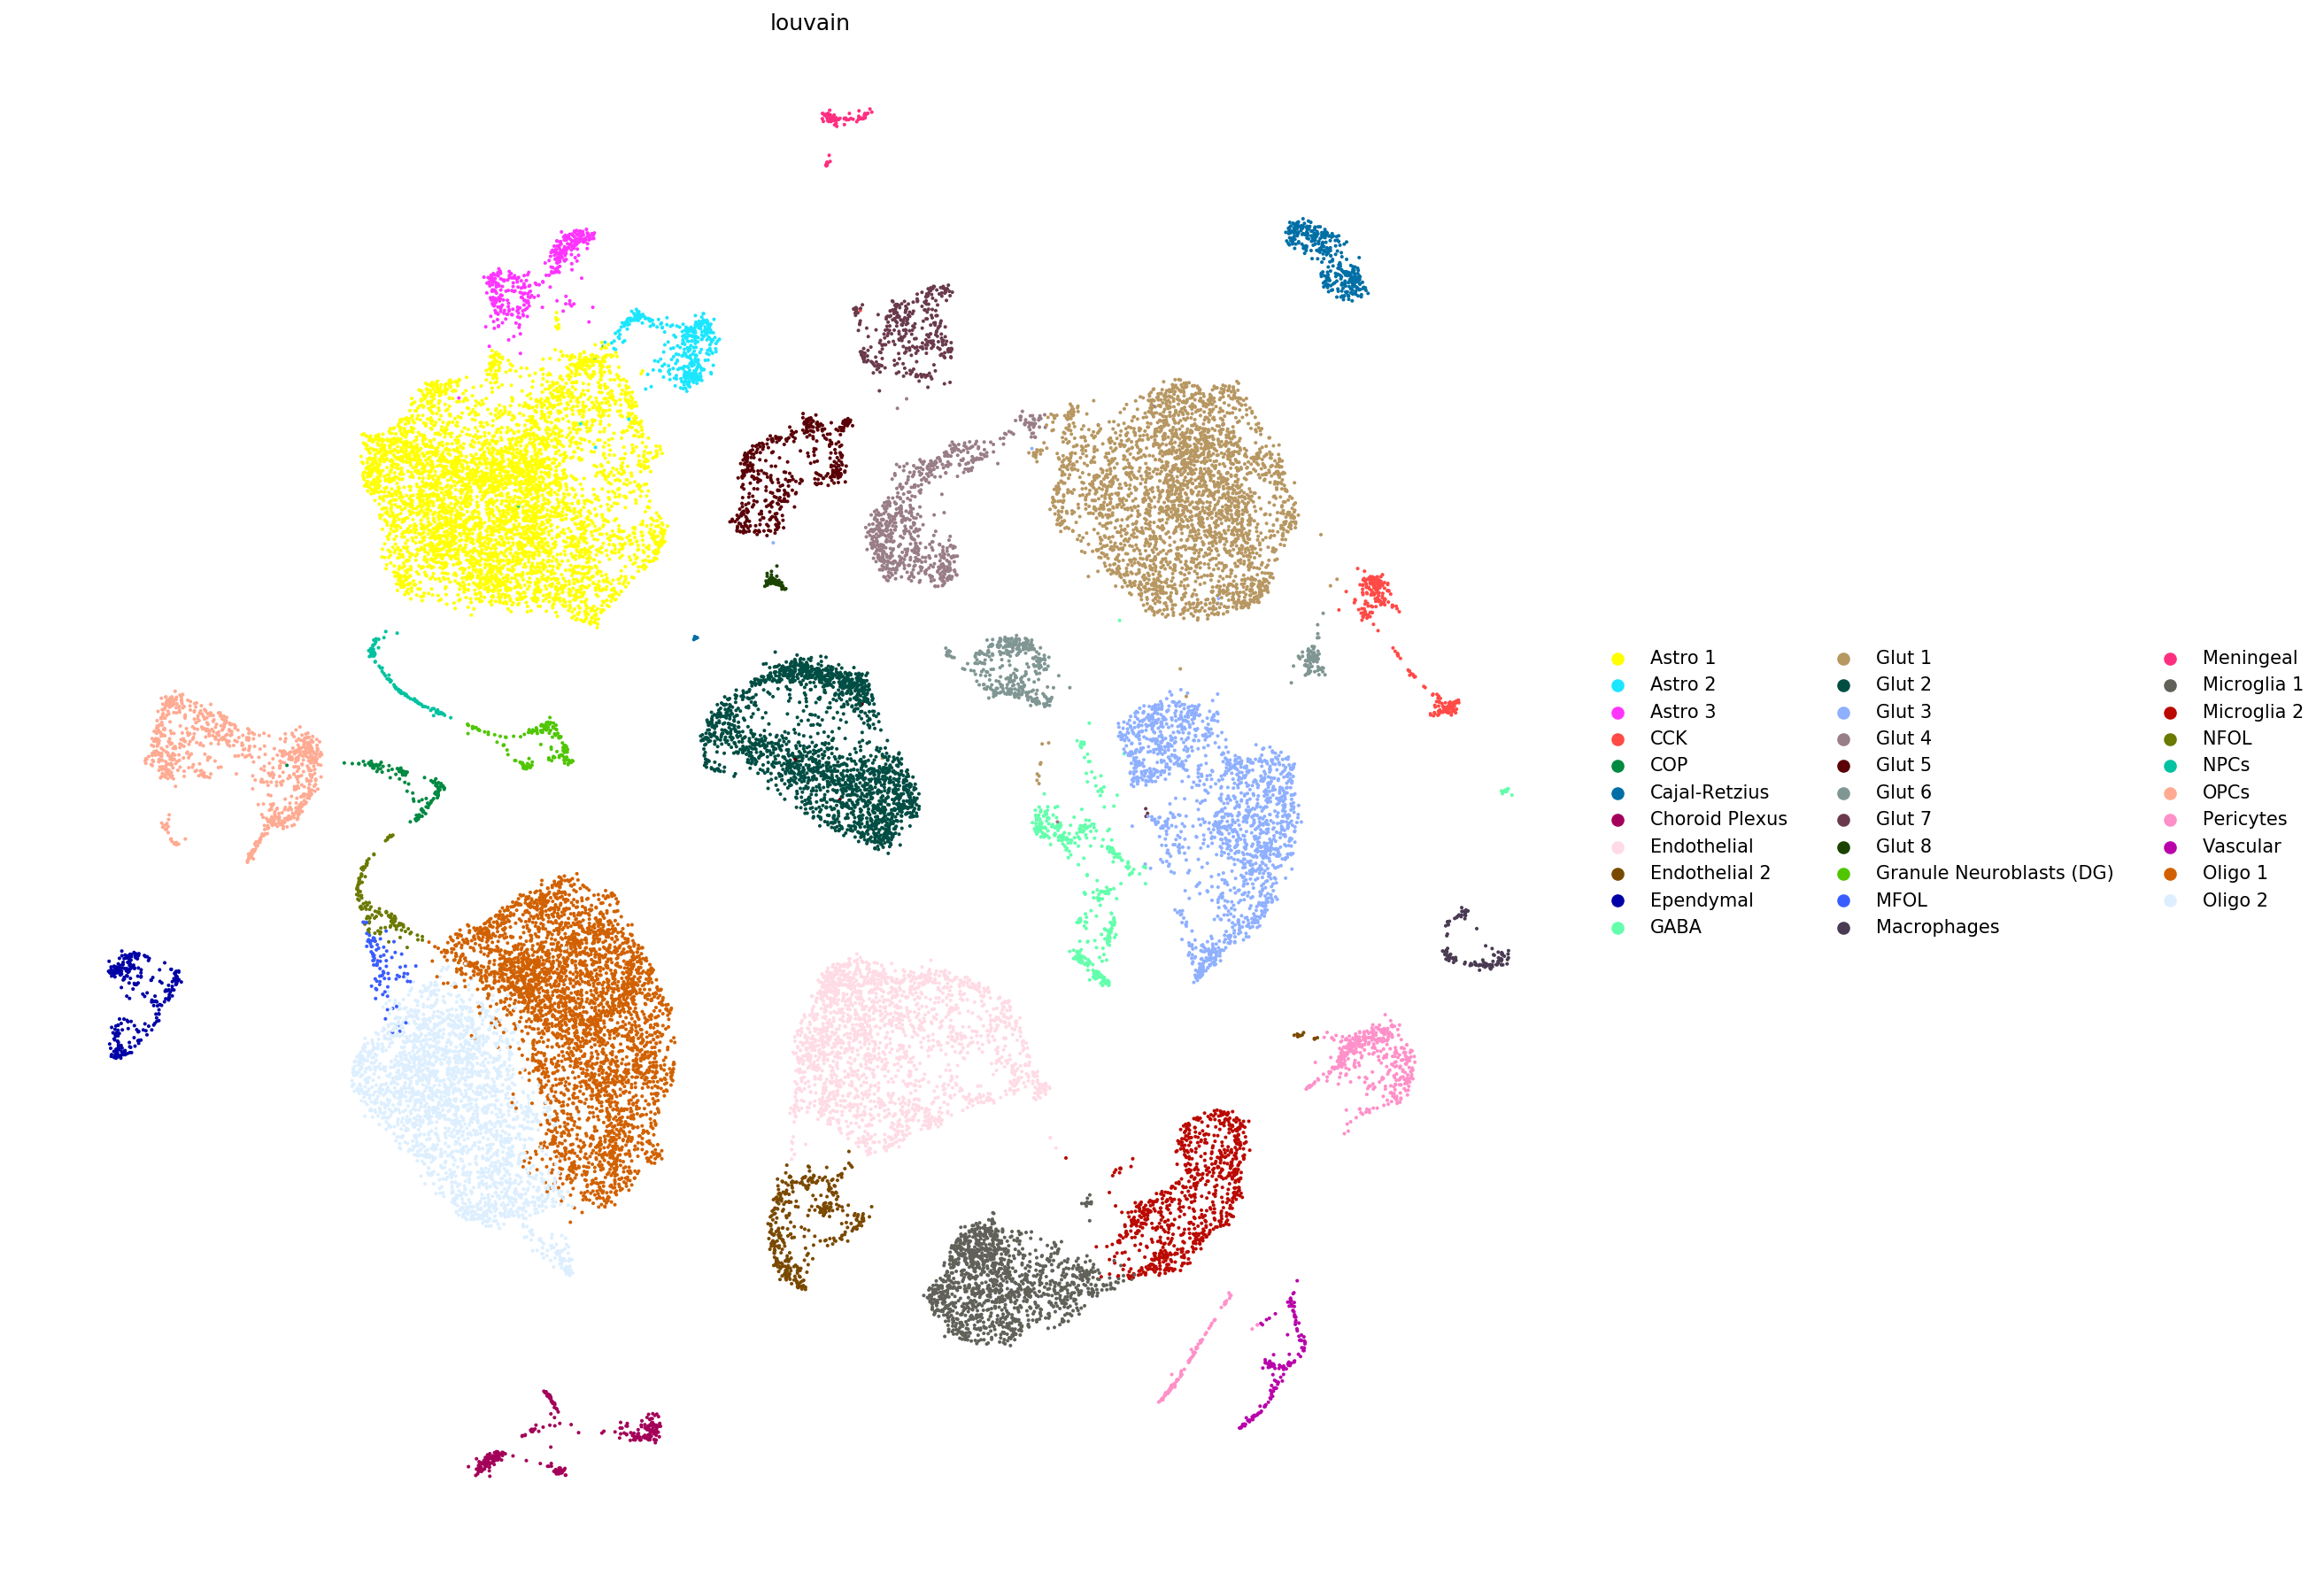

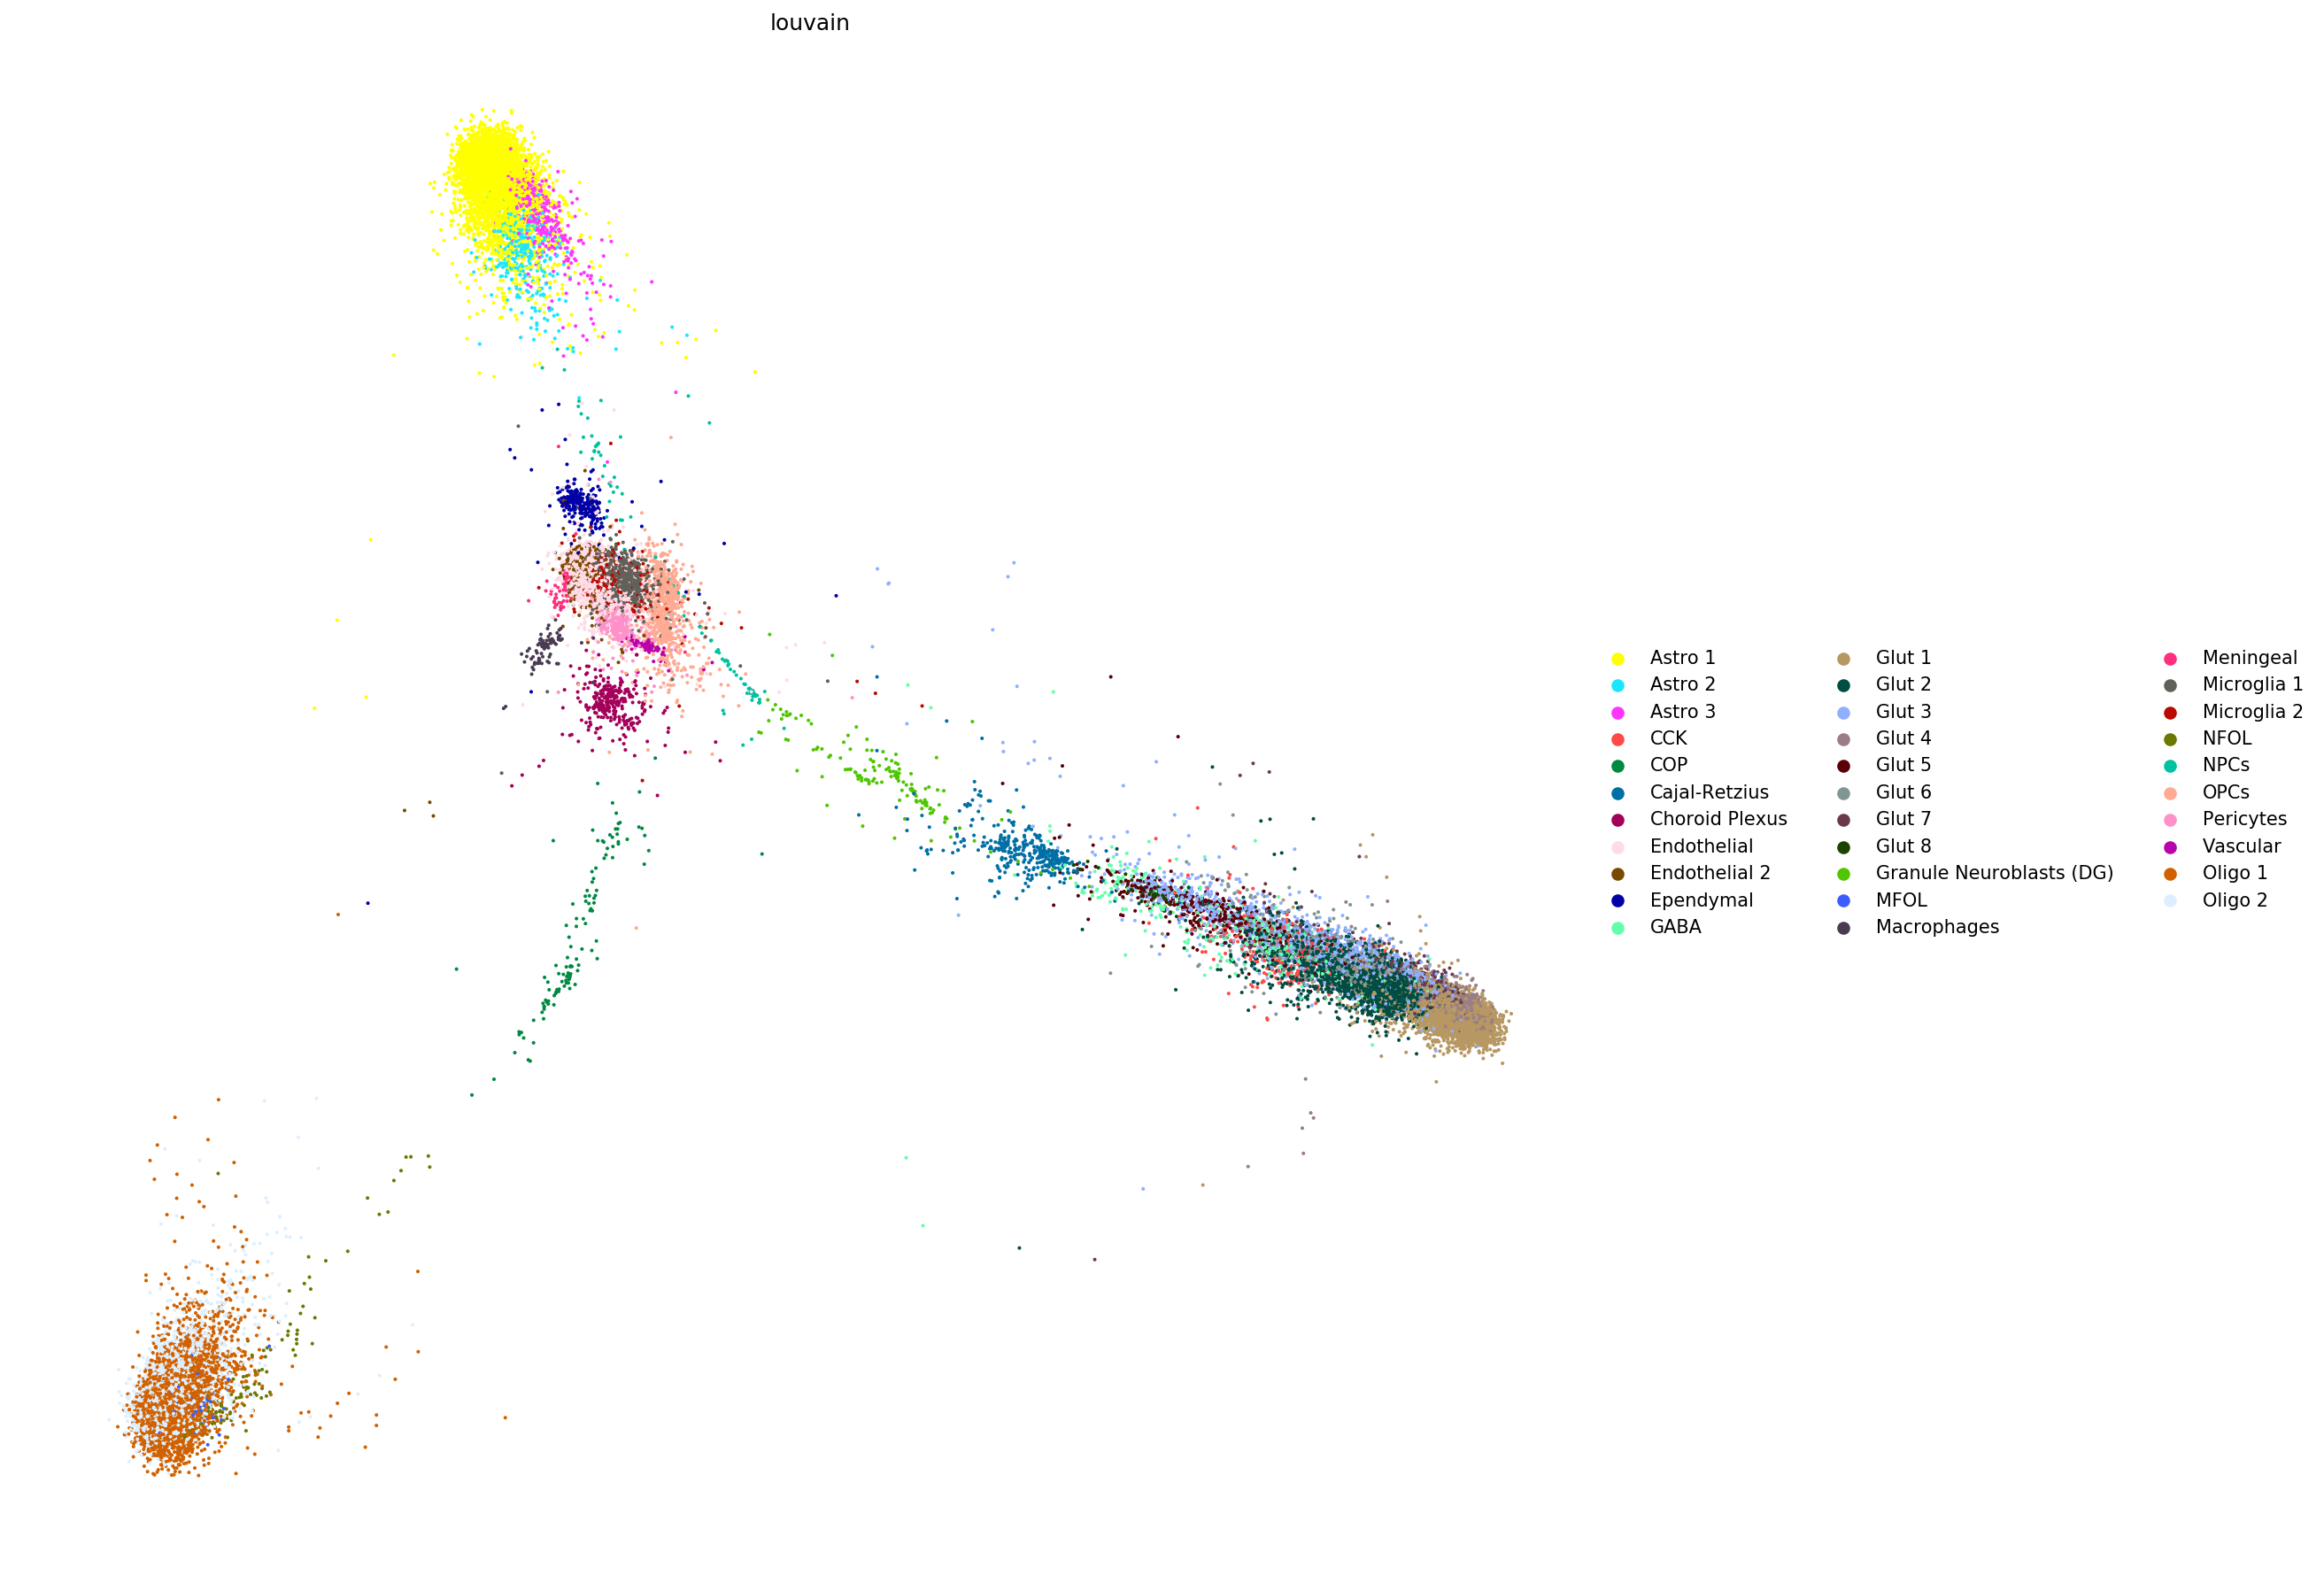

In [7]:
plt.rcParams['figure.figsize']=(15, 15)
sc.pl.umap(adata, color='louvain', size=15, frameon=False)
sc.pl.pca(adata, color='louvain', size=15, frameon=False)

In [8]:
sc.pp.highly_variable_genes(adata_raw, n_top_genes=4000, flavor='cell_ranger', subset=True)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [45]:
adata_de = adata.copy()

In [9]:
adata_bl = adata_raw[adata_raw.obs['baseline']=='BL'].copy()

In [10]:
adata_bl.obs = adata_bl.obs.rename(columns={'sample_id':'sample'})

In [11]:
adata_bl.obs.columns

Index(['G2M_score', 'S_score', 'adult_stress', 'baseline', 'batch',
       'condition', 'log_counts', 'louvain', 'louvain_high_res', 'mt_fraction',
       'n_counts', 'n_genes', 'phase', 'sample', 'sample_name', 'size_factors',
       'umap_density_adult_stress'],
      dtype='object')

In [12]:
adata_bl.obs['condition'] = adata_bl.obs['condition'].cat.rename_categories({'BL_Ctrl':'Ctrl',
                                                                            'BL_Stress':'Stress'})

In [13]:
adata_bl.obs['condition']

index
AAACCCAAGGATGCGT-1-2-2        Ctrl
AAACCCACACAGCCTG-1-2-2        Ctrl
AAACCCAGTGTGGACA-1-2-2        Ctrl
AAACCCAGTTACACAC-1-2-2        Ctrl
AAACGAAAGACGCCAA-1-2-2        Ctrl
                             ...  
TTTGGTTAGAGGTCGT-1-11-11    Stress
TTTGGTTAGGTGATAT-1-11-11    Stress
TTTGGTTCAAATGGAT-1-11-11    Stress
TTTGGTTCACGTAGAG-1-11-11    Stress
TTTGTTGGTCCACGCA-1-11-11    Stress
Name: condition, Length: 13001, dtype: category
Categories (2, object): [Ctrl, Stress]

In [14]:
from rpy2 import robjects
def mast_de_groups(adata, groupby, save):
    '''Compute differential expression with the MAST package by treatment covariate within clusters provided as "groupby" and export as excel file'''
    
    #if groupby not in ['louvain_final', 'louvain_three']:
    #    raise NotImplementedError("This function is only implemented to be used with 'louvain_final' and 'louvain_three' group labels")
    
    # Define R function to run MAST analysis
    robjects.r('''
        mast_de_r <- function(data_mat, clusters, obs, var, groupby){
            print('Deploying to R...')
            #Prepare data sets for SingleCellExperiment data structure conversion
            obs['wellKey'] = row.names(obs)
            var['primerid'] = row.names(var)

            #Convert to SingleCellExperiment type
            sca <- FromMatrix(exprsArray=data_mat, cData=obs, fData=var)

            #Compute Gene detection rate
            cdr <- colSums(assay(sca)>0)
            colData(sca)$ngeneson = scale(cdr)

            colData(sca)$n_genes = scale(colData(sca)$n_genes)
            #Create a vector that will hold all the DE results
            output <- vector("list", length(clusters))

            count <- 0
            print('Begin computation...')
            #Loop over all louvain clusters
            for (i in clusters){
                count <- count+1
                print(i)
                #Create data subsets which should be used for testing
                if (groupby=='louvain') {
                    sca_sub <- sca[,colData(sca)$louvain==i]
                } else if (groupby=='louvain_r1') {
                    sca_sub <- subset(sca, with(colData(sca), louvain_r1==i))
                } else {
                    stop()
                }
                #Filter out non-expressed genes in the subset
                sca_sub <- sca_sub[rowSums(assay(sca_sub)) != 0, ]
                #Define & run hurdle model
                zlmCond <- zlm(formula = ~condition + n_genes + sample, sca=sca_sub)
                summaryCond <- summary(zlmCond, doLRT='conditionStress')
                summaryDt <- summaryCond$datatable
                result <- merge(summaryDt[contrast=='conditionStress' & component=='H',.(primerid, `Pr(>Chisq)`)], #p-vals
                                 summaryDt[contrast=='conditionStress' & component=='logFC', .(primerid, coef)], #logFC coefficients
                                 by='primerid') 
                #Correct for multiple testing (FDR correction) and filtering
                result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
                result[,coef:=result[,coef]/log(2)]
                names(result) <- c("gene", "pval", "log2FC", "qval")
                result = result[order(result$qval),]
                print('debug4')
                output[[count]] <- result
                print('debug5')
            }
            return(output)
        }
    ''')
    
    mast_de = robjects.globalenv['mast_de_r']
    

    
    #Create new Anndata object for use in MAST with non-batch corrected data as before
    adata_test = adata.copy()
    adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) 
    obs = adata_test.obs
    var = adata_test.var
    data_mat = adata_test.X.T
    clusters = list(adata_test.obs[groupby].cat.categories)
    
    expr_dict = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_stress = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_ctrl = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    for clust in adata_test.obs[groupby].cat.categories:
        expr = np.mean(adata_test[adata_test.obs[groupby] == clust].X, axis=0)
        expr_stress = np.mean(adata_test[(adata_test.obs['condition']=='Stress') & (adata_test.obs[groupby] == clust)].X, axis=0)
        expr_ctrl = np.mean(adata_test[(adata_test.obs['condition']=='Control') & (adata_test.obs[groupby] == clust)].X, axis=0)
        for i, gene in enumerate(adata_test.var.index):
            expr_dict[gene][clust] = expr[i]
            expr_dict_stress[gene][clust] = expr_stress[i]
            expr_dict_ctrl[gene][clust] = expr_ctrl[i]
    
    result = mast_de(data_mat, clusters, obs, var, groupby)
    result = {clusters[i]:datframe for i, datframe in enumerate(result)}
    
    writer = pd.ExcelWriter(save, engine='xlsxwriter')
    print('Number of significant DE genes:')    
    for clust in clusters:
        result[clust]['meanExpr'] = [expr_dict[gene][clust] for gene in result[clust]['gene'].values]
        result[clust]['meanExprStress'] = [expr_dict_stress[gene][clust] for gene in result[clust]['gene'].values]
        result[clust]['meanExprCtrl'] = [expr_dict_ctrl[gene][clust] for gene in result[clust]['gene'].values]
        result[clust].to_excel(writer,sheet_name=str(clust))
        print(clust+':', np.sum([result[clust]['qval']<0.05]))

    writer.save()

    return result

In [ ]:
de = mast_de_groups(adata_bl, groupby='louvain', save='../results/mast_de_baseline.xlsx')

/app/python37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/app/python37/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[1] "Deploying to R..."
[1] "Begin computation..."
[1] "Astro 1"


In [15]:
adata_bl

AnnData object with n_obs × n_vars = 13600 × 3999 
    obs: 'G2M_score', 'S_score', 'adult_stress', 'baseline', 'batch', 'condition', 'log_counts', 'louvain', 'louvain_high_res', 'mt_fraction', 'n_counts', 'n_genes', 'phase', 'sample_id', 'sample_name', 'size_factors', 'umap_density_adult_stress'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'counts'

In [12]:
%%R -i adata_bl
print(adata_bl)


class: SingleCellExperiment 
dim: 3999 13600 
metadata(0):
assays(2): X counts
rownames(3999): Sox17 Rgs20 ... E330013P04Rik AC168977.1
rowData names(4): highly_variable means dispersions dispersions_norm
colnames(13600): AAACCCAAGGATGCGT-1-2-2 AAACCCACACAGCCTG-1-2-2 ...
  TTTGTTGCATTGCTTT-1-10-10 TTTGTTGTCGTTAGTG-1-10-10
colData names(17): G2M_score S_score ... size_factors
  umap_density_adult_stress
reducedDimNames(0):
spikeNames(0):
altExpNames(0):


In [18]:
%%R
print(length(c(colData(adata_bl)$louvain == 'Astro 1')))
print(dim(adata_bl))

[1] 13600
[1]  3999 13600


In [21]:
%%R
sca_sub <- adata_bl[, colData(adata_bl)$louvain=='Astro 1']